# It's Raaaaiiiining Skin. Hallelujah! 
# It's Raining Skin. 
Amen

This week I am jumping into a dataset obtained from the site below. It contains 17,000 images of 114 labeled skin conditions, which have been grouped into 9 more broad categories and then 3 even bigger categories. I have the option to classify as finely or broad as I'd like. The data has also been annotated by a multiple people for skin color using the Fitzpatrick Scale.

For the project, I will use the CSV provided to sort the images into a directory of train, test, and validation folders with subfolders for each skin condition coded 0-8. I will then resize and scale the data to fit into my Convolutional Neural Networks. I will build one of my own and optimize it as much as I can. 

After that, I would like to find a pre-built CNN that may work even better. I will use transfer learning to boost my model's effeciency by using pre-trained weights and biases, saving computational time and effort. I will describe my thought process and methods as I go, and will summarize the best model I have produced. 

Only then, will I research model accuracy from other's who've attempted to classify this same dataset to see how I stack up. 


Dataset obtained from:
https://github.com/mattgroh/fitzpatrick17k/blob/main/README.md

In [72]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/var/folders/67/4r4vrm1j7bd5nhk477q0b5km0000gn/T/ipykernel_11761/1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [235]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, shutil # Library for navigating files
from keras import backend as K
from keras import backend, models, layers, optimizers, regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from IPython.display import display # Library to help view images
from PIL import Image # Library to help view images
from keras.preprocessing.image import ImageDataGenerator # Library for data augmentation
from keras.preprocessing import image
from keras.utils import plot_model
import warnings
import csv

np.random.seed(1)

In [74]:
base_dir = 'finalfitz17k'

----
Above, I assigned a base directory for finding the images. 

Below, I will connect the images to the labels in the cleanfitz.csv file I've cleaned up to include the image name and label- one of nine skin condition categories. 

----

In [75]:
derm = pd.read_csv('cleanfitz.csv')
derm

,md5hash,nine_partition_label
0,5e82a45bc5d78bd24ae9202d194423f8,inflammatory
1,fa2911a9b13b6f8af79cb700937cc14f,inflammatory
2,d2bac3c9e4499032ca8e9b07c7d3bc40,benign dermal
3,0a94359e7eaacd7178e06b2823777789,inflammatory
4,a39ec3b1f22c08a421fa20535e037bba,inflammatory
...,...,...
16572,cd90e491ddaa92f0f4eb07f73aa09f64,inflammatory
16573,5f1ed6de6a9110d7dc580a6a0312af63,inflammatory
16574,f198aaf1f0550c2464b285454d34926e,inflammatory
16575,6214de2e915835014235a1839cbc5938,inflammatory


In [76]:
derm.nine_partition_label.unique()

array(['inflammatory', 'benign dermal', 'malignant dermal',
       'malignant melanoma', 'genodermatoses', 'malignant epidermal',
       'benign epidermal', 'benign melanocyte',
       'malignant cutaneous lymphoma'], dtype=object)

In [77]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

derm['nine_partition_label'] = derm['nine_partition_label'].astype('category')
derm['label'] = derm['nine_partition_label'].cat.codes

newdata = pd.DataFrame(encoder.fit_transform(
    derm[['label']]).toarray())
  
# Merge with main
derm = derm.join(newdata)
derm

,md5hash,nine_partition_label,label,0,1,2,3,4,5,6,7,8
0,5e82a45bc5d78bd24ae9202d194423f8,inflammatory,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,fa2911a9b13b6f8af79cb700937cc14f,inflammatory,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,d2bac3c9e4499032ca8e9b07c7d3bc40,benign dermal,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0a94359e7eaacd7178e06b2823777789,inflammatory,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,a39ec3b1f22c08a421fa20535e037bba,inflammatory,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16572,cd90e491ddaa92f0f4eb07f73aa09f64,inflammatory,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16573,5f1ed6de6a9110d7dc580a6a0312af63,inflammatory,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16574,f198aaf1f0550c2464b285454d34926e,inflammatory,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16575,6214de2e915835014235a1839cbc5938,inflammatory,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [78]:
derm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16577 entries, 0 to 16576
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   md5hash               16577 non-null  object  
 1   nine_partition_label  16577 non-null  category
 2   label                 16577 non-null  int8    
 3   0                     16577 non-null  float64 
 4   1                     16577 non-null  float64 
 5   2                     16577 non-null  float64 
 6   3                     16577 non-null  float64 
 7   4                     16577 non-null  float64 
 8   5                     16577 non-null  float64 
 9   6                     16577 non-null  float64 
 10  7                     16577 non-null  float64 
 11  8                     16577 non-null  float64 
dtypes: category(1), float64(9), int8(1), object(1)
memory usage: 1.3+ MB


In [79]:
drop_cols = ['nine_partition_label', 0, 1, 2, 3, 4, 5, 6, 7, 8]

derm = derm.drop(drop_cols, axis = 1)
derm

,md5hash,label
0,5e82a45bc5d78bd24ae9202d194423f8,4
1,fa2911a9b13b6f8af79cb700937cc14f,4
2,d2bac3c9e4499032ca8e9b07c7d3bc40,0
3,0a94359e7eaacd7178e06b2823777789,4
4,a39ec3b1f22c08a421fa20535e037bba,4
...,...,...
16572,cd90e491ddaa92f0f4eb07f73aa09f64,4
16573,5f1ed6de6a9110d7dc580a6a0312af63,4
16574,f198aaf1f0550c2464b285454d34926e,4
16575,6214de2e915835014235a1839cbc5938,4


In [80]:
derm['md5hash'] = derm['md5hash'].astype(str) + '.jpg'
derm

,md5hash,label
0,5e82a45bc5d78bd24ae9202d194423f8.jpg,4
1,fa2911a9b13b6f8af79cb700937cc14f.jpg,4
2,d2bac3c9e4499032ca8e9b07c7d3bc40.jpg,0
3,0a94359e7eaacd7178e06b2823777789.jpg,4
4,a39ec3b1f22c08a421fa20535e037bba.jpg,4
...,...,...
16572,cd90e491ddaa92f0f4eb07f73aa09f64.jpg,4
16573,5f1ed6de6a9110d7dc580a6a0312af63.jpg,4
16574,f198aaf1f0550c2464b285454d34926e.jpg,4
16575,6214de2e915835014235a1839cbc5938.jpg,4


In [81]:
derm.label = derm.label.astype('category')

In [83]:
derm.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16577 entries, 0 to 16576
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   md5hash  16577 non-null  object  
 1   label    16577 non-null  category
dtypes: category(1), object(1)
memory usage: 146.2+ KB


____

Below, the histogram of the labels shows that the data is skewed in favor of the 4 label. Label 4 accounts for almost 60% of all images

___

<Axes: title={'center': 'Image Label Count'}, ylabel='Frequency'>

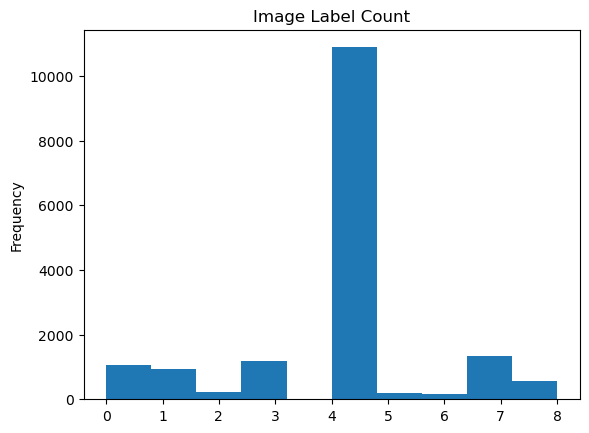

In [271]:
derm.label.plot(kind = 'hist', title = 'Image Label Count')

In [96]:
data = np.random.randint(0,100,size=16577)

derm['randomnumber'] = data 
derm

,Unnamed: 0,md5hash,label,randomnumber
0,0,5e82a45bc5d78bd24ae9202d194423f8.jpg,4,66
1,1,fa2911a9b13b6f8af79cb700937cc14f.jpg,4,79
2,2,d2bac3c9e4499032ca8e9b07c7d3bc40.jpg,0,22
3,3,0a94359e7eaacd7178e06b2823777789.jpg,4,86
4,4,a39ec3b1f22c08a421fa20535e037bba.jpg,4,53
...,...,...,...,...
16572,16572,cd90e491ddaa92f0f4eb07f73aa09f64.jpg,4,32
16573,16573,5f1ed6de6a9110d7dc580a6a0312af63.jpg,4,31
16574,16574,f198aaf1f0550c2464b285454d34926e.jpg,4,68
16575,16575,6214de2e915835014235a1839cbc5938.jpg,4,45


In [119]:
derm = derm.drop('Unnamed: 0', axis = 1)

In [120]:
derm

,md5hash,label,randomnumber
0,5e82a45bc5d78bd24ae9202d194423f8.jpg,4,66
1,fa2911a9b13b6f8af79cb700937cc14f.jpg,4,79
2,d2bac3c9e4499032ca8e9b07c7d3bc40.jpg,0,22
3,0a94359e7eaacd7178e06b2823777789.jpg,4,86
4,a39ec3b1f22c08a421fa20535e037bba.jpg,4,53
...,...,...,...
16572,cd90e491ddaa92f0f4eb07f73aa09f64.jpg,4,32
16573,5f1ed6de6a9110d7dc580a6a0312af63.jpg,4,31
16574,f198aaf1f0550c2464b285454d34926e.jpg,4,68
16575,6214de2e915835014235a1839cbc5938.jpg,4,45


In [110]:
derm.to_csv('cleanfitz1.csv')

____
Below, I will make directories for the files to be moved to.

___

In [111]:
# create directories of train, valid, test with files 0-8 in each. 

imgfolder = 'finalfitz17k/'
folderlist = ['trainfolder','validfolder','testfolder']
  
for items in folderlist:
    path = os.path.join(imgfolder, items)
    os.mkdir(path)


FileExistsError: [Errno 17] File exists: 'finalfitz17k/trainfolder'

In [ ]:
folderpath = 'finalfitz17k/trainfolder'
folderlist = ['0','1','2', '3', '4', '5', '6', '7', '8']

for items in folderlist:
    path = os.path.join(folderpath, items)
    os.mkdir(path)

In [90]:
folderpath = 'finalfitz17k/validfolder'
folderlist = ['0','1','2', '3', '4', '5', '6', '7', '8']

for items in folderlist:
    path = os.path.join(folderpath, items)
    os.mkdir(path)

In [91]:
folderpath = 'finalfitz17k/testfolder'
folderlist = ['0','1','2', '3', '4', '5', '6', '7', '8']

for items in folderlist:
    path = os.path.join(folderpath, items)
    os.mkdir(path)

In [147]:

for index, row in derm.iterrows():
  if row['randomnumber'] in range(0,26) :
    shutil.move('finalfitz17k/' + str(row['md5hash']), 'finalfitz17k/testfolder/' + str(row['label']))
  elif row['randomnumber'] in range (26,36):
    shutil.move('finalfitz17k/' + str(row['md5hash']), 'finalfitz17k/validfolder/' + str(row['label']))
  else:
    shutil.move('finalfitz17k/' + str(row['md5hash']), 'finalfitz17k/trainfolder/' + str(row['label']))



In [148]:
base_dir = 'finalfitz17k/'

In [149]:
train_dir = os.path.join(base_dir, 'trainfolder')
validation_dir = os.path.join(base_dir, 'validfolder')
test_dir = os.path.join(base_dir, 'testfolder')

In [151]:
# Specify the classess in the training, validataion, and test directories

train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')
train_2_dir = os.path.join(train_dir, '2')
train_3_dir = os.path.join(train_dir, '3')
train_4_dir = os.path.join(train_dir, '4')
train_5_dir = os.path.join(train_dir, '5')
train_6_dir = os.path.join(train_dir, '6')
train_7_dir = os.path.join(train_dir, '7')
train_8_dir = os.path.join(train_dir, '8')

validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')
validation_2_dir = os.path.join(validation_dir, '2')
validation_3_dir = os.path.join(validation_dir, '3')
validation_4_dir = os.path.join(validation_dir, '4')
validation_5_dir = os.path.join(validation_dir, '5')
validation_6_dir = os.path.join(validation_dir, '6')
validation_7_dir = os.path.join(validation_dir, '7')
validation_8_dir = os.path.join(validation_dir, '8')

test_0_dir = os.path.join(test_dir, '0')
test_1_dir = os.path.join(test_dir, '1')
test_2_dir = os.path.join(test_dir, '2')
test_3_dir = os.path.join(test_dir, '3')
test_4_dir = os.path.join(test_dir, '4')
test_5_dir = os.path.join(test_dir, '5')
test_6_dir = os.path.join(test_dir, '6')
test_7_dir = os.path.join(test_dir, '7')
test_8_dir = os.path.join(test_dir, '8')

In [152]:
# We need to normalize the pixels in the images.  The data will 'flow' through this generator.
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [153]:
# Since the file images are in a directory we need to move them from the directory into the model.  
# Keras as a function that makes this easy. Documentaion is here: https://keras.io/preprocessing/image/

train_generator = train_datagen.flow_from_directory(
    train_dir, # The directory where the train data is located
    target_size=(150, 150), # Reshape the image to 150 by 150 pixels. This is important because it makes sure all images are the same size.
    batch_size=20, # We will take images in batches of 20.
    class_mode='categorical') # The classification is binary.

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

Found 10623 images belonging to 9 classes.
Found 1618 images belonging to 9 classes.
Found 4336 images belonging to 9 classes.


In [249]:

import os

import cv2

---
#### Some pictures are graphic. This was one of the least shocking to scroll to.
--------

In [268]:
path = "finalfitz17k/testfolder/0"

files = os.listdir(path)

for file in files[:10]:

    file_path = os.path.join(path, file)

    img = cv2.imread(file_path)

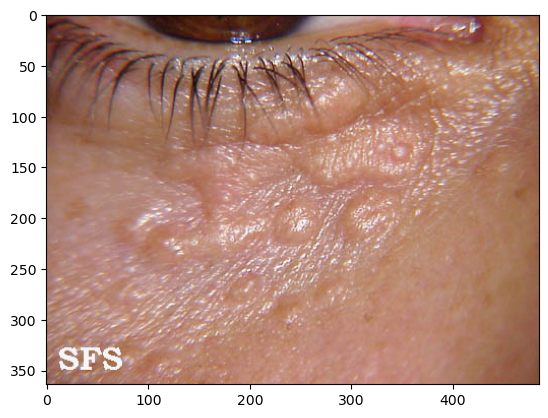

In [269]:
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

___

Next, I will build the plotting function to see the validation and training accuracy and loss for each model that I run. 

____

In [172]:
def plot_history(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc_values = history_dict['accuracy']
  val_acc_values = history_dict['val_accuracy']
  epochs = range(1, len(history_dict['accuracy']) + 1)

  plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
  plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
  plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  return plt.show()

____

#### I will build a basic Convolutional Neural Network to set base expectations. Since I know that the dataset is skewed towards label 4, I would say that the minimum accuracy would be about .6. This is because, based on the histogram above, it looks like a guess of 4 for every entry will give me a 60% accuracy. 

I will start with a Convolutional layer, input shape matches my generators above. I will keep the pooling kernel size at a standard 2x2 and apply padding = same so that the outside pixels are given the same weight as the inside. These pictures are not centered or organized in any way, and the skin condition could be anywhere in the image. I will employ batch normalization to try to combat overfitting. 

____

Epoch 1/50
100/100 [==============================] - 128s 1s/step - loss: 30.4666 - accuracy: 0.4251 - val_loss: 1.9319 - val_accuracy: 0.4940
Epoch 2/50
100/100 [==============================] - 128s 1s/step - loss: 14.4720 - accuracy: 0.5174 - val_loss: 2.0500 - val_accuracy: 0.6660
Epoch 3/50
100/100 [==============================] - 141s 1s/step - loss: 5.5635 - accuracy: 0.5945 - val_loss: 1.9608 - val_accuracy: 0.6680
Epoch 4/50
100/100 [==============================] - 127s 1s/step - loss: 2.6157 - accuracy: 0.6405 - val_loss: 4.4761 - val_accuracy: 0.2750
Epoch 5/50
100/100 [==============================] - 123s 1s/step - loss: 2.1211 - accuracy: 0.6596 - val_loss: 2.1288 - val_accuracy: 0.6840
Epoch 6/50
100/100 [==============================] - 1968s 20s/step - loss: 1.9717 - accuracy: 0.6560 - val_loss: 1.8593 - val_accuracy: 0.6420
Epoch 7/50
100/100 [==============================] - 127s 1s/step - loss: 1.8093 - accuracy: 0.6680 - val_loss: 2.7717 - val_accuracy: 0.

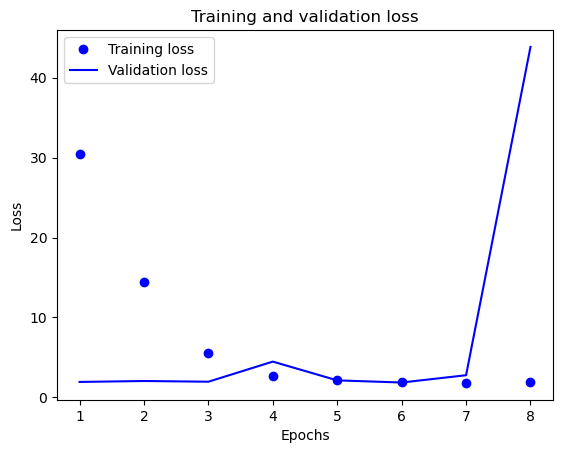

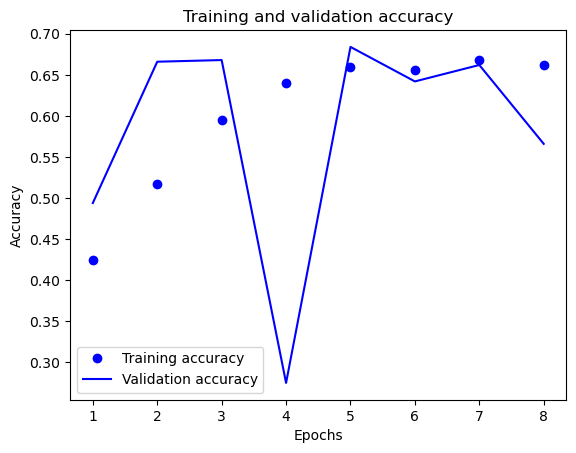

50/50 [==============================] - 17s 339ms/step - loss: 2.1794 - accuracy: 0.6640
test_acc: 0.6639999747276306


In [174]:
def Base_CNN():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(184, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(100, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(9, activation='softmax'))

  model.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

model = Base_CNN()

history = model.fit( 
    train_generator, 
    steps_per_epoch=100, 
    epochs=50, 
    validation_data=validation_generator, 
    validation_steps=50, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)]) 

plot_history(history) 

test_loss, test_acc =model.evaluate(test_generator, steps = 50) 

print('test_acc:', test_acc)

___

The first model stayed right around 66% for most of the epochs. I was surprised that the train and validation accuracy stayed close to each other, not displaying much overfitting. I'm on the right track with the Batch Normalization and Dropout. The test acuracy finished at 66.4%. My validation plot lines are still very jumpy. 

For the second model, I will add another Convolutional layer along with Max pooling and Batch Norm to try to learn more from the images. 

_____

Epoch 1/50
100/100 [==============================] - 164s 2s/step - loss: 9.8916 - accuracy: 0.4395 - val_loss: 18.4212 - val_accuracy: 0.0720
Epoch 2/50
100/100 [==============================] - 158s 2s/step - loss: 5.7546 - accuracy: 0.5120 - val_loss: 13.3150 - val_accuracy: 0.5780
Epoch 3/50
100/100 [==============================] - 145s 1s/step - loss: 3.8316 - accuracy: 0.5760 - val_loss: 16.0405 - val_accuracy: 0.1270
Epoch 4/50
100/100 [==============================] - 144s 1s/step - loss: 2.5538 - accuracy: 0.6105 - val_loss: 11.6155 - val_accuracy: 0.5550
Epoch 5/50
100/100 [==============================] - 142s 1s/step - loss: 2.0049 - accuracy: 0.6395 - val_loss: 3.9936 - val_accuracy: 0.6430
Epoch 6/50
100/100 [==============================] - 151s 2s/step - loss: 1.7524 - accuracy: 0.6535 - val_loss: 2.2776 - val_accuracy: 0.6540
Epoch 7/50
100/100 [==============================] - 146s 1s/step - loss: 1.6972 - accuracy: 0.6596 - val_loss: 1.7700 - val_accuracy: 0.

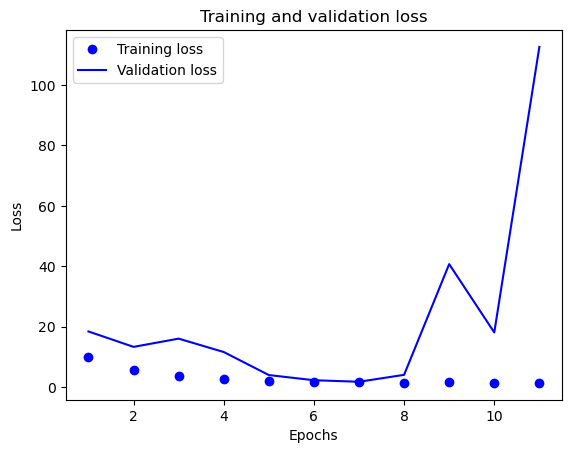

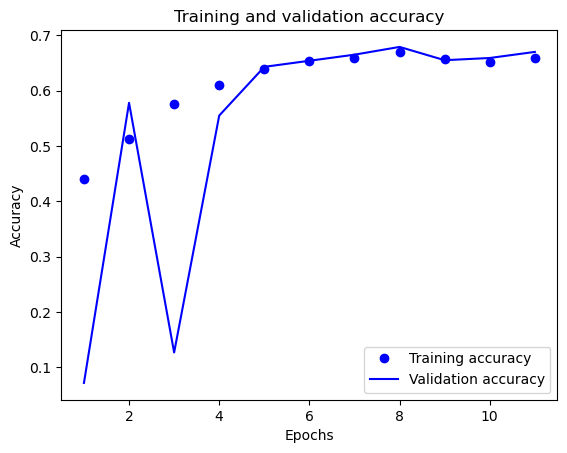

50/50 [==============================] - 20s 401ms/step - loss: 3.8601 - accuracy: 0.6430
test_acc: 0.6430000066757202


In [175]:
def Base_CNN():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(184, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(121, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(121, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(9, activation='softmax'))

  model.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

model = Base_CNN()

history = model.fit( 
    train_generator, 
    steps_per_epoch=100, 
    epochs=50, 
    validation_data=validation_generator, 
    validation_steps=50, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)])

plot_history(history) 

test_loss, test_acc =model.evaluate(test_generator, steps = 50) 

print('test_acc:', test_acc)

_____
The model above only reached 64.3% test accuracy. The plots are interesting because they seem opposite in their learning. The validation loss skyrockets at the end. Whereas, the validation accuracy is jumpy in the beginning but shows alot of promise towards the end. 

For the third model attempt, I want to add a couple layers of Convolution, Pooling and Batch Norm to see if I can get to a higher train accuracy. That has even been low on the last models. I know I can always get a model to overfit, then pull back. To see if I'm missing out with early stopping, I will experiment with lengths of more than 3. 

I read that, ideally, channels should increase as the model goes on, but that is the opposite of what I have been trying, so I will attempt that as well. 

_____

Epoch 1/50
100/100 [==============================] - 63s 620ms/step - loss: 2.0667 - accuracy: 0.5185 - val_loss: 2.0491 - val_accuracy: 0.1710
Epoch 2/50
100/100 [==============================] - 61s 610ms/step - loss: 1.7456 - accuracy: 0.5698 - val_loss: 1.8546 - val_accuracy: 0.3650
Epoch 3/50
100/100 [==============================] - 61s 604ms/step - loss: 1.6133 - accuracy: 0.5850 - val_loss: 1.4710 - val_accuracy: 0.6270
Epoch 4/50
100/100 [==============================] - 64s 637ms/step - loss: 1.5399 - accuracy: 0.6250 - val_loss: 2.3406 - val_accuracy: 0.6620
Epoch 5/50
100/100 [==============================] - 63s 631ms/step - loss: 1.4172 - accuracy: 0.6340 - val_loss: 3.8930 - val_accuracy: 0.6450
Epoch 6/50
100/100 [==============================] - 60s 599ms/step - loss: 1.3685 - accuracy: 0.6610 - val_loss: 1.9292 - val_accuracy: 0.6360
Epoch 7/50
100/100 [==============================] - 60s 594ms/step - loss: 1.3852 - accuracy: 0.6505 - val_loss: 1.4156 - val_ac

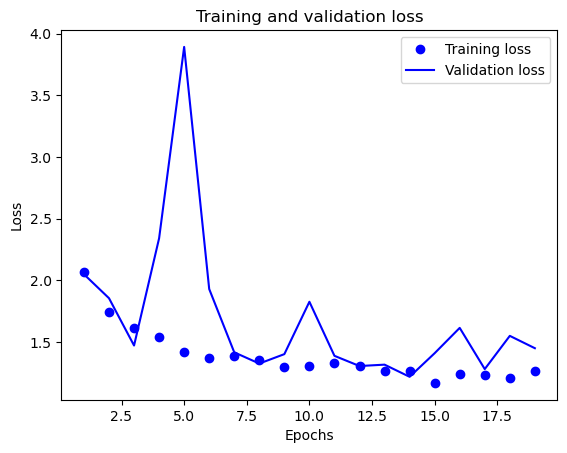

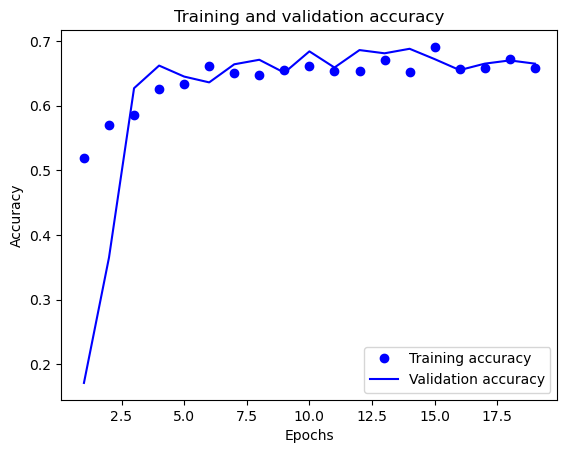

50/50 [==============================] - 10s 202ms/step - loss: 1.2621 - accuracy: 0.6690
test_acc: 0.6690000295639038


In [179]:
def Base_CNN3():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(80, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(121, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(121, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(184, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Flatten())
  model.add(layers.Dense(121, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(9, activation='softmax'))

  model.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

model3 = Base_CNN3()

history = model3.fit( 
    train_generator, 
    steps_per_epoch=100, 
    epochs=50, 
    validation_data=validation_generator, 
    validation_steps=50, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)]) 

plot_history(history) 

test_loss, test_acc =model3.evaluate(test_generator, steps = 50) 

print('test_acc:', test_acc)

____

The 3rd model with added layers and opposite channel configuration did slightly better but one tenth of a percent is not statistically significant. The plots are starting to even out more though, and the train and test accuracies are not far apart. 5 seemed to be the happy medium for the early stop setting. 


Next, I will try kernel regularization. These incorporate penalties into the loss which are then used to change the weights and biases. One that we didn't use in class was the Orthaganal Regulizer. According to the Keras documentation, this regulizer 'encourages vectors to be orthogonal to each other', aka at right angles. This can be used on either rows or columns. Rows is default. 

Unfortunately, Orthogonal was throwing an error with my input values. I'm not sure I can use it on this dataset. I was unable to resolve the error, so I switched to using L1 regulizer. 

____

Epoch 1/50
100/100 [==============================] - 64s 630ms/step - loss: 52.3358 - accuracy: 0.4790 - val_loss: 12.4593 - val_accuracy: 0.6820
Epoch 2/50
100/100 [==============================] - 64s 638ms/step - loss: 9.7866 - accuracy: 0.5345 - val_loss: 7.7397 - val_accuracy: 0.6920
Epoch 3/50
100/100 [==============================] - 66s 659ms/step - loss: 8.2130 - accuracy: 0.5750 - val_loss: 7.2744 - val_accuracy: 0.6780
Epoch 4/50
100/100 [==============================] - 59s 588ms/step - loss: 7.6592 - accuracy: 0.5935 - val_loss: 7.3415 - val_accuracy: 0.6760
Epoch 5/50
100/100 [==============================] - 60s 599ms/step - loss: 7.0812 - accuracy: 0.6390 - val_loss: 5.8478 - val_accuracy: 0.6730
Epoch 6/50
100/100 [==============================] - 60s 603ms/step - loss: 6.8195 - accuracy: 0.6425 - val_loss: 6.3983 - val_accuracy: 0.6770
Epoch 7/50
100/100 [==============================] - 65s 646ms/step - loss: 6.5925 - accuracy: 0.6480 - val_loss: 7.2357 - val_

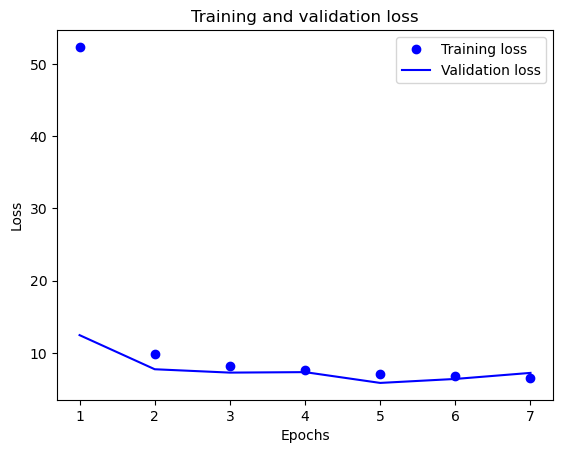

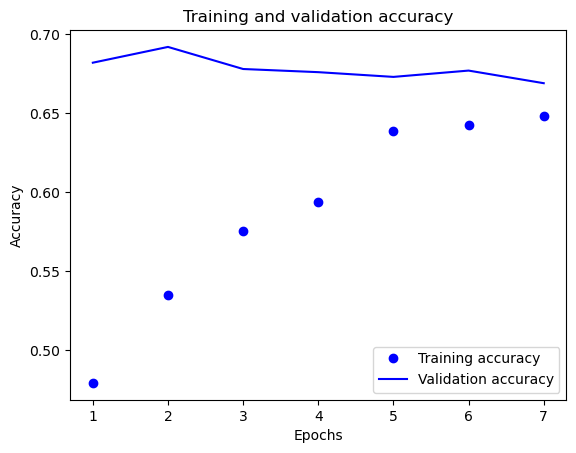

50/50 [==============================] - 10s 203ms/step - loss: 7.7905 - accuracy: 0.6410
test_acc: 0.640999972820282


In [183]:
def Base_CNN4():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(80, (3,3), kernel_regularizer='l1', activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(121, (3,3), kernel_regularizer='l1', activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(121, (3,3), kernel_regularizer='l1', activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(184, (3,3), kernel_regularizer='l1', activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Flatten())
  model.add(layers.Dense(184, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(9, activation='softmax'))

  model.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

model4 = Base_CNN4()

history = model4.fit( 
    train_generator, 
    steps_per_epoch=100, 
    epochs=50, 
    validation_data=validation_generator, 
    validation_steps=50, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)]) 

plot_history(history) 

test_loss, test_acc =model4.evaluate(test_generator, steps = 50) 

print('test_acc:', test_acc)

____

Model 4 with L1 regularization is not showing any added promise. I think I've tried to optimize this quite a bit and haven't gotten very far. 

Next, I'd like to try a pretrained model for transfer learning. Xception was recommended for image classification, and I haven't used it yet. 

____

In [197]:
from keras.applications import Xception

In [204]:
backend.clear_session()
xbase = Xception(weights = 'imagenet',  
                  include_top = False,
                  pooling = max,
                  input_shape = (150, 150, 3))

In [205]:
xbase.trainable = False

Epoch 1/50
100/100 [==============================] - 116s 1s/step - loss: 6.1919 - accuracy: 0.5103 - val_loss: 5.4199 - val_accuracy: 0.6800
Epoch 2/50
100/100 [==============================] - 110s 1s/step - loss: 5.2550 - accuracy: 0.5517 - val_loss: 4.3858 - val_accuracy: 0.5040
Epoch 3/50
100/100 [==============================] - 112s 1s/step - loss: 4.7591 - accuracy: 0.5717 - val_loss: 6.8996 - val_accuracy: 0.4040
Epoch 4/50
100/100 [==============================] - 109s 1s/step - loss: 4.3246 - accuracy: 0.5785 - val_loss: 3.7709 - val_accuracy: 0.6320
Epoch 5/50
100/100 [==============================] - 128s 1s/step - loss: 4.2026 - accuracy: 0.5991 - val_loss: 4.4165 - val_accuracy: 0.5427
Epoch 6/50
100/100 [==============================] - 127s 1s/step - loss: 3.9827 - accuracy: 0.6150 - val_loss: 4.7813 - val_accuracy: 0.4573


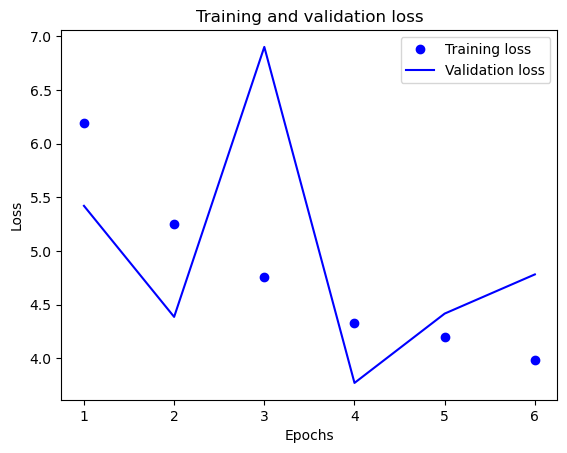

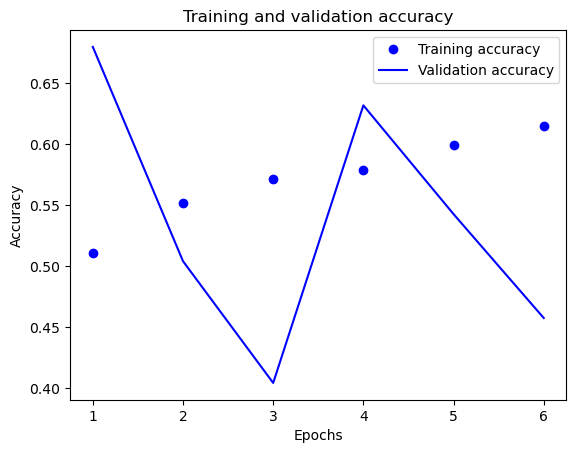

50/50 [==============================] - 16s 320ms/step - loss: 7.7986 - accuracy: 0.6367
test_acc: 0.6366666555404663


In [219]:
def CNNModel5():
  backend.clear_session()
  model = models.Sequential()
  model.add(xbase) 
  model.add(layers.Flatten()) 
  model.add(layers.Dense(9, activation = 'softmax')) 

  model.compile(optimizer = 'rmsprop',
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])

  return model

model5 = CNNModel5()

history = model5.fit( 
    train_generator, 
    steps_per_epoch=100,
    epochs=50, 
    validation_data=validation_generator, 
    validation_steps=50, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)]) 
plot_history(history) 

test_loss, test_acc =model4.evaluate(test_generator, steps = 50) 

print('test_acc:', test_acc)


____

Model 5, above, used transfer learning from a pre-built CNN, but the accuracy is slightly lower than any model I have built. The plots showed alot of jumpiness between epochs. I tried increaseing the batch size in the train/test/valid genearators to combat this, but it made it worse on this model. At this point, I do not think unfreezing layers and making the model more tedius is going to help my accuracy, so I will move on. 


Next, I want to try data augmentation. I think that I do have a pretty large data set, but since some classes have less representation than others, it might be possibe for data augmentation to help. 

This will require some backtracking to create a new data generator code. 

The augmentation code below will roate the image 20 degrees, and change the other metrics by 10%.

___

In [222]:
aug_datagen = ImageDataGenerator( 
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1,
    zoom_range=0.1, 
    horizontal_flip=True,  
    fill_mode='nearest'
    )

In [223]:
train_generator = aug_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='categorical') 

validation_generator = aug_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

Found 10623 images belonging to 9 classes.
Found 1618 images belonging to 9 classes.
Found 4336 images belonging to 9 classes.


Model3 showed the most promise from above, so that is the one that I will use for the data augmentation model. 

Epoch 1/50
100/100 [==============================] - 68s 662ms/step - loss: 2.1581 - accuracy: 0.5149 - val_loss: 3.2892 - val_accuracy: 0.6300
Epoch 2/50
100/100 [==============================] - 67s 669ms/step - loss: 1.8331 - accuracy: 0.5660 - val_loss: 4.5566 - val_accuracy: 0.6760
Epoch 3/50
100/100 [==============================] - 63s 634ms/step - loss: 1.6541 - accuracy: 0.5920 - val_loss: 2.9034 - val_accuracy: 0.6400
Epoch 4/50
100/100 [==============================] - 64s 639ms/step - loss: 1.5640 - accuracy: 0.6230 - val_loss: 2.6378 - val_accuracy: 0.5170
Epoch 5/50
100/100 [==============================] - 64s 638ms/step - loss: 1.5582 - accuracy: 0.6100 - val_loss: 1.9988 - val_accuracy: 0.5700
Epoch 6/50
100/100 [==============================] - 65s 648ms/step - loss: 1.3659 - accuracy: 0.6660 - val_loss: 1.6004 - val_accuracy: 0.6630
Epoch 7/50
100/100 [==============================] - 68s 681ms/step - loss: 1.3937 - accuracy: 0.6485 - val_loss: 3.3204 - val_ac

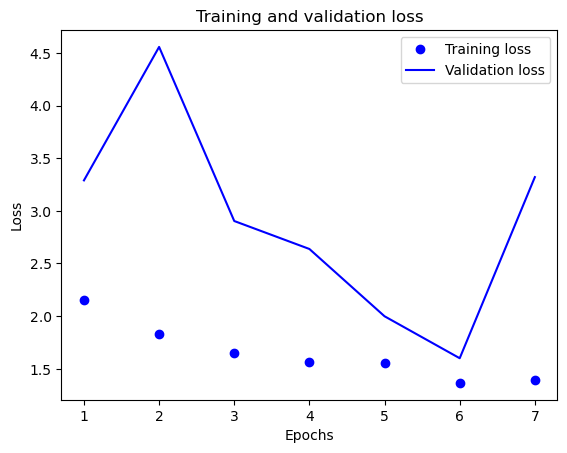

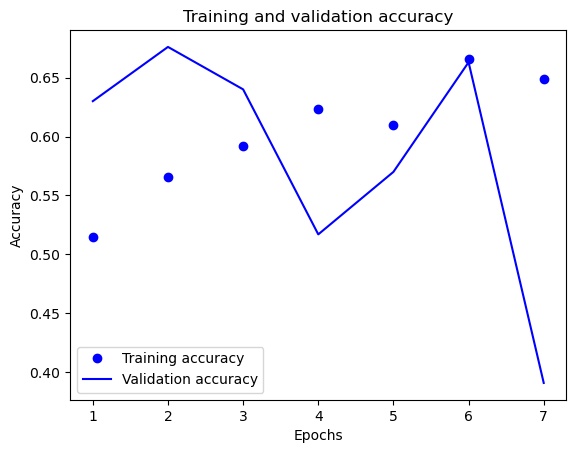

50/50 [==============================] - 10s 197ms/step - loss: 21.0934 - accuracy: 0.6350
test_acc: 0.6349999904632568


In [224]:
def Base_CNN6():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(80, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(121, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(121, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(184, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Flatten())
  model.add(layers.Dense(121, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(9, activation='softmax'))

  model.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

model6 = Base_CNN6()

history = model6.fit( 
    train_generator, 
    steps_per_epoch=100, 
    epochs=50, 
    validation_data=validation_generator, 
    validation_steps=50, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)]) 

plot_history(history) 

test_loss, test_acc =model6.evaluate(test_generator, steps = 50) 

print('test_acc:', test_acc)

_____

The data augmentation did not give me the accuracy boost I had hoped for. My validation plots for Model 6 are all over the place. I want to see if optimizing the learning rate will help. Default for RMSProp is .001. I will change it to .01.

______

In [229]:
import tensorflow as tf


Epoch 1/50
100/100 [==============================] - 75s 734ms/step - loss: 4.7428 - accuracy: 0.5220 - val_loss: 8.2027 - val_accuracy: 0.6660
Epoch 2/50
100/100 [==============================] - 69s 691ms/step - loss: 1.4960 - accuracy: 0.6536 - val_loss: 1.5267 - val_accuracy: 0.6680
Epoch 3/50
100/100 [==============================] - 71s 710ms/step - loss: 1.3827 - accuracy: 0.6385 - val_loss: 1.3351 - val_accuracy: 0.6610
Epoch 4/50
100/100 [==============================] - 69s 686ms/step - loss: 1.3203 - accuracy: 0.6605 - val_loss: 1.2479 - val_accuracy: 0.6770
Epoch 5/50
100/100 [==============================] - 66s 669ms/step - loss: 1.2832 - accuracy: 0.6581 - val_loss: 1.2272 - val_accuracy: 0.6790
Epoch 6/50
100/100 [==============================] - 68s 684ms/step - loss: 1.2501 - accuracy: 0.6685 - val_loss: 1.2569 - val_accuracy: 0.6690
Epoch 7/50
100/100 [==============================] - 68s 678ms/step - loss: 1.2472 - accuracy: 0.6690 - val_loss: 1.2978 - val_ac

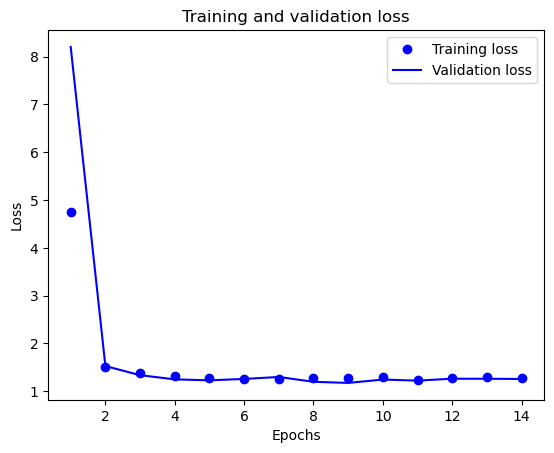

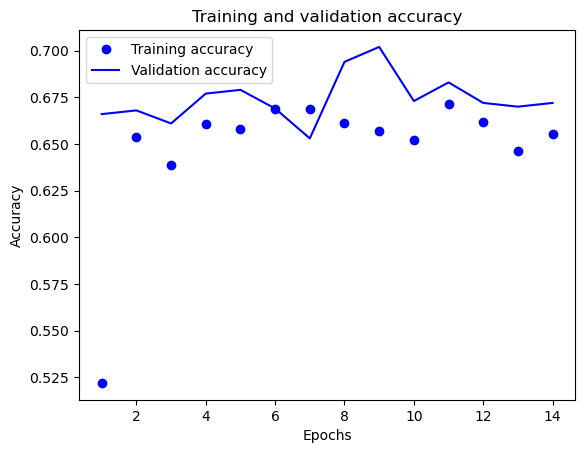

50/50 [==============================] - 10s 198ms/step - loss: 1.3255 - accuracy: 0.6440
test_acc: 0.6439999938011169


In [230]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)

def Base_CNN7():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(80, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(121, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(121, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(184, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2), padding = 'same'))
  model.add(layers.BatchNormalization())

  model.add(layers.Flatten())
  model.add(layers.Dense(121, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(9, activation='softmax'))

  model.compile(optimizer = opt,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

model7 = Base_CNN7()

history = model7.fit( 
    train_generator, 
    steps_per_epoch=100, 
    epochs=50, 
    validation_data=validation_generator, 
    validation_steps=50, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)]) 

plot_history(history)

test_loss, test_acc =model7.evaluate(test_generator, steps = 50) 

print('test_acc:', test_acc)

------
# Summary

My model never achieved the accuracy I was aiming for. I thought I could get test accuracy above 80% with enough tuning. However, 67% was the best I could produce. Model 3 had the best results. I found this through 5 Convolutional Neural Network Layers with Max Pooling, Padding = Same, Batch Normalization, and then Droput at the end. In Model3, I employed channel design that went from smaller to larger, which I hadn't tried before. This model performed less than a percent better than the rest. 

Although I have a large dataset to work with, the dataset was skewed heavily towards label 4. Another difficulty faced was the quality of pictures. The skin condition was often not what I would consider the focus of the image. Hair sometimes covered the skin. Although, I did hope the data augmentation would help with this. 

Overall, this project made me realize that little changes/standardization in picture procedures could make the quality of this dataset immensely better. Doctors are already collecting images of every suspicious condition. Consent for and guidelines for these images should be a priority in building datasets for the dermatology and data science community. I believe that with quality, labeled images, a neural network could be the first defense in skin cancer detection. 

I could not find much published on this exact dataset, but Matt Groh and his associates published a paper that was focused more on the skin color bias, but it did include this confusion matrix of the data when the team classified it into 3 labels (instead of the 9 that I did). Instead of using the whole dataset, they kept it divided by the two sources they collected from using one as the train and one as the test set. Their results made me feel alot better about how my model performed. Matrix shown below. 

https://openaccess.thecvf.com/content/CVPR2021W/ISIC/papers/Groh_Evaluating_Deep_Neural_Networks_Trained_on_Clinical_Images_in_Dermatology_CVPRW_2021_paper.pdf

In [239]:
  
Image(url="matt_groh_results.png", width=400, height=300)